# Exploring heart disease data obtained by the Cleveland Clinic

## Introduction
Our topic revolves around heart disease, specifically attempting to build a model that will predict, given certain factors that will be explained shortly, if a person does have heart disease. We chose to examine biological information of heart-disease patients at the Cleveland Clinic Foundation. This data set is one of 4 which are available at [https://archive.ics.uci.edu/dataset/45/heart+disease] in a zip file. This dataset contains 303 observations with 14 variables each; 164 of the patients have no heart disease whereas 139 have heart disease. As such, the overarching question that we seek to answer is: **Given the stated variables (see methods), does that person have heart disease?**

## Preliminary exploratory data analysis

First, we will load the tidyverse package to be able to perform data analysis and visualization. This proposal document requires that the tidyverse, tidymodels and gridExtra R packages be downloaded.

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
set.seed(54321)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Next we read in the data from the file available on the web, first by unzipping the file and then accessing only the data set we want. Although the dataset was provided as a .data file from the original source, the file contains comma-separated values, so we use read_csv. Since the data has no column names, we will rename them all using information available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [2]:
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_temp <- tempfile()
download.file(url, heart_temp)
data <- read_csv(unzip(heart_temp, "processed.cleveland.data"), col_names = FALSE, show_col_types = FALSE) |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4,
           cholesterol = X5, fasting_blood_sugar = X6,
           resting_ecg = X7, max_heart_rate = X8, exercise_angina = X9,
           st_depression = X10, slope = X11, major_vessels = X12, thal = X13,
           diagnosis = X14)
unlink(heart_temp)

Now since we don't want to use every variable in the data set, we will select only those that we are interested in: age, sex (only for prelim analysis), maximum heart rate achieved, ST depression, thal, and diagnosis. Also, the authors of the data have indicated that all values 1-4 of the diagnosis variable mean a positive diagnosis, and only 0 indicates a negative diagnosis, so we will combine values 1-4 into 1 to simplify the data because our goal is only to determine the presence of heart disease.

In [3]:
data_selected <- data |>
    select(age, sex, max_heart_rate, st_depression, thal, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

glimpse(data_selected)

Rows: 303
Columns: 6
$ age            <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44,…
$ sex            <dbl> 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0…
$ max_heart_rate <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, …
$ st_depression  <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, …
$ thal           <chr> "6.0", "3.0", "7.0", "3.0", "3.0", "3.0", "3.0", "3.0",…
$ diagnosis      <fct> 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0…


Now we will split the data into a training and testing set for the preliminary data analysis and building our classification model.

In [4]:
data_split <- initial_split(data_selected)
data_training <- training(data_split)
data_testing <- testing(data_split)

Since the data is already tidy, our next step is to explore the data. In order to better visualize the data, the variables that are actually categories but are stored as integers (i.e. sex, chest pain, and fasting blood sugar) will be converted to factor variables. The explanations of the numerical categories were provided by the authors of the data set, available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [5]:
data_converted <- data_training |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0"))

data_converted <- data_converted |>
    mutate(diagnosis = fct_recode(diagnosis,
                            "Angiographic disease" = "1",
                            "Healthy" = "0"))

data_converted <- data_converted |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal,
                             "Normal" = "3.0",
                             "Fixed defect" = "6.0",
                             "Reversable defect" = "7.0")) |>
    mutate(thal = fct_relevel(thal, "Reversable defect", after = 1))

glimpse(data_converted)

Rows: 227
Columns: 6
$ age            <dbl> 58, 52, 63, 57, 71, 57, 55, 57, 52, 62, 49, 58, 59, 35,…
$ sex            <fct> Male, Male, Male, Male, Female, Male, Male, Male, Male,…
$ max_heart_rate <dbl> 131, 169, 144, 126, 125, 143, 111, 115, 158, 99, 162, 1…
$ st_depression  <dbl> 2.2, 0.0, 4.0, 1.5, 1.6, 3.0, 5.6, 1.2, 0.8, 1.8, 0.0, …
$ thal           <fct> Reversable defect, Normal, Reversable defect, Fixed def…
$ diagnosis      <fct> Angiographic disease, Healthy, Angiographic disease, He…


Here we see that the data values were successfully renamed. Now we will summarize some information about the data, including counting the number of observations for each diagnosis, the number of males vs. females, the average of our numerical predictor variables (age, maximum heart rate, and st_depression), and the number of rows with missing values in the data set (note that the authors of the data set specified that -9.0 is used in place of missing values).

In [6]:
number_of_observations <- data_converted |>
    group_by(diagnosis) |>
    summarize(count = n())

genders <- data_converted |>
    group_by(sex) |>
    summarize(count = n())

mean_values <- data_converted |>
    select(age, max_heart_rate, st_depression) |>
    summarize(mean_age = mean(age), mean_max_maximum_heart_rate = mean(max_heart_rate), mean_st_depression = mean(st_depression))

missing_data <- data_converted |>
    filter(age == -9.0 | sex == "-9.0" | max_heart_rate == -9.0 | st_depression == -9.0 | thal == "-9.0" |
           diagnosis == "-9.0" | sex == "?" | thal == "?" | diagnosis == "?")

number_of_missing_data <- missing_data |>
    summarize(number_of_missing_values = n())

number_of_observations
genders
mean_values
number_of_missing_data
missing_data

diagnosis,count
<fct>,<int>
Healthy,125
Angiographic disease,102


sex,count
<fct>,<int>
Female,75
Male,152


mean_age,mean_max_maximum_heart_rate,mean_st_depression
<dbl>,<dbl>,<dbl>
54.59912,149.8018,0.9823789


number_of_missing_values
<int>
1


age,sex,max_heart_rate,st_depression,thal,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
53,Female,115,0,?,Healthy


So we see that, luckily, only 1 row has missing data. To make it more useful, we will rename the "?" to N/A in the code below. Additionally, we see that the classes appear to be roughly balanced, with around the same number of positive diagnoses as negative (healthy).

In [7]:
data_converted <- mutate(data_converted, thal = if_else(thal == "?", NA, thal))

data_missing <- filter(data_converted, if_any(everything(), is.na)) # check that the above code worked
data_missing

age,sex,max_heart_rate,st_depression,thal,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
53,Female,115,0,NA,Healthy


Now we further explore the data by visualizing it in order to discern any patterns in the data.

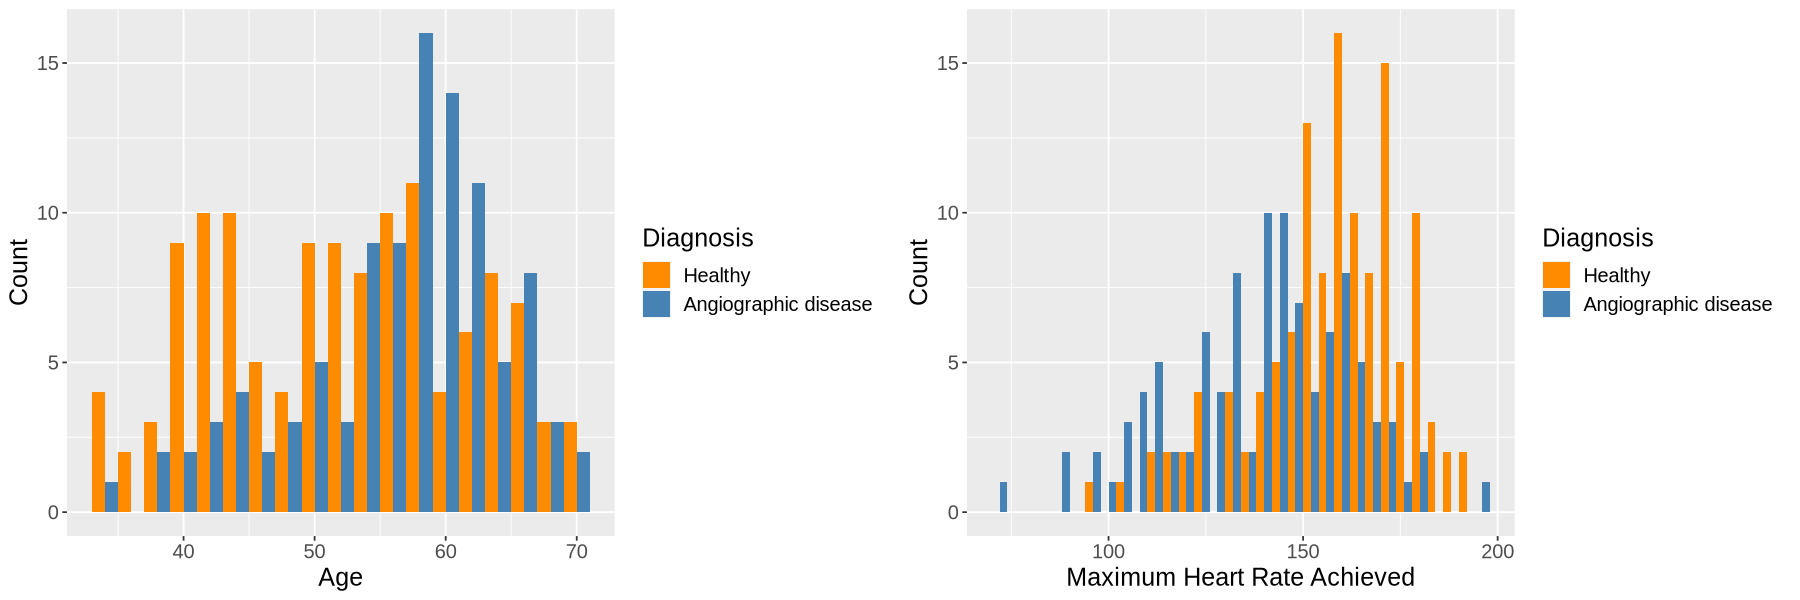

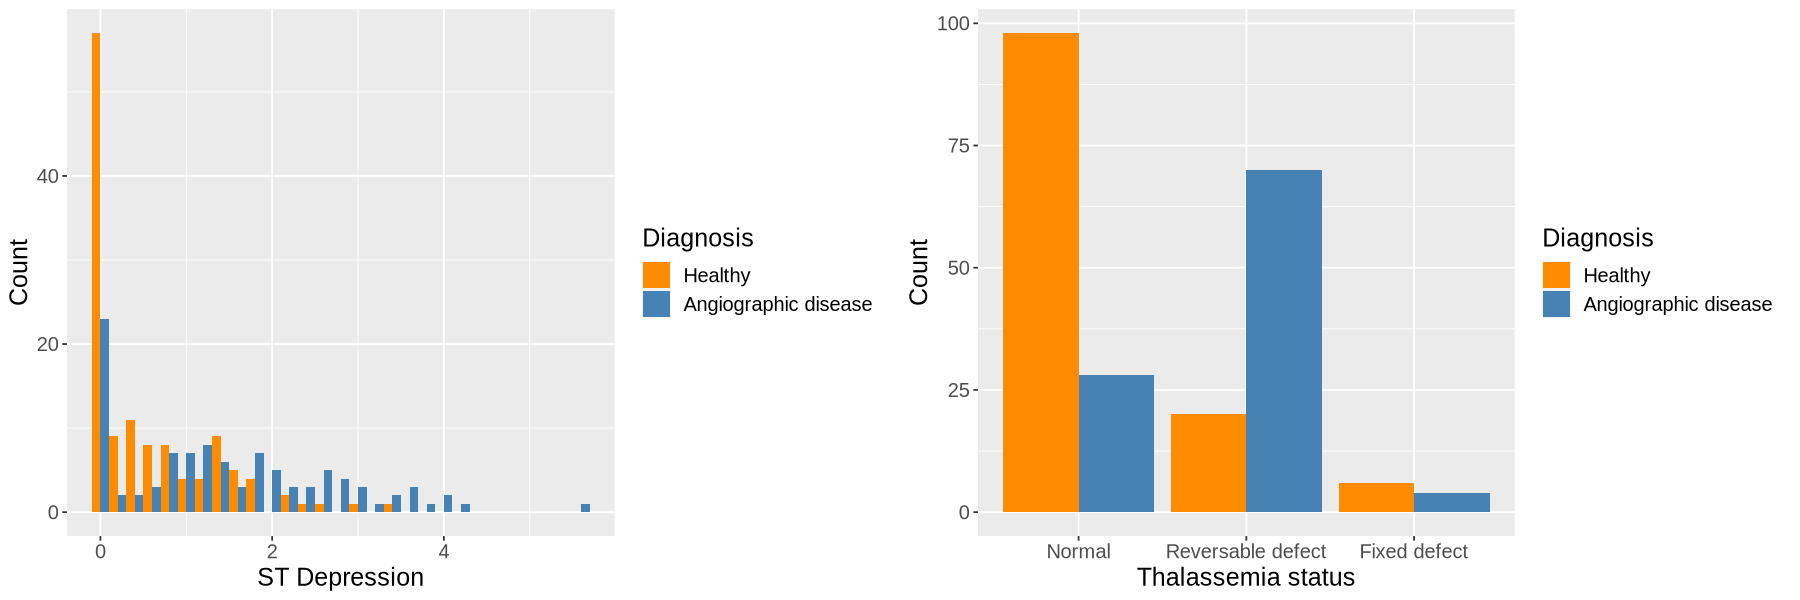

In [8]:
graph_age <- data_converted |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 2) +
    labs(x = "Age", y = "Count", fill = "Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

graph_heart_rate <- data_converted |>
    ggplot(aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 4) +
    labs(x = "Maximum Heart Rate Achieved", y = "Count", fill = "Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

graph_st_depression <- data_converted |>
    ggplot(aes(x = st_depression, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 0.2) +
    labs(x = "ST Depression", y = "Count", fill = "Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

graph_thal <- data_converted |>
    drop_na() |>
    ggplot(aes(x = thal, fill = diagnosis)) +
    geom_bar(position = "dodge") +
    labs(x = "Thalassemia status", y = "Count", fill = "Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

options(repr.plot.width = 15, repr.plot.height = 5)
grid.arrange(graph_age, graph_heart_rate, ncol = 2)
grid.arrange(graph_st_depression, graph_thal, ncol = 2)

From the graphs, the diagnosis of an individual appears to have a correlation with maximum heart rate, age, thal, and st_depression.

# Methods
In the preliminary analysis above, we found that the explanatory variables that have an association with our class variable (diagnosis) are the following 4 out of 14: 
- Maximum heart rate achieved by the patient (bpm)
- Age of patient
- Status of the patient's thalassemia (a blood disorder)
- ST depression (measured by ECG)

We plan to input these 4 variables into a K-Nearest Neighbor classification model, where we can teach R to predict whether or not a patient has heart disease. The remaining 10 variables were excluded since they appeared to have no association with our class variable. The exclusion of these variables ensures that our classification is not influenced by unrelated variables. We will conduct cross-validation to pick our optimal number of neighbors `K`. Our parameter `K` will determine how many neighbors will be used to classify our new observation, this ensures that our model has optimal accuracy and reduced error in our class prediction. 

To visualize our decision of choosing an optimal `K`, we will create a line plot that shows the relationship between our parameter `K` (within a reasonable range) and the accuracy of our classification model. This allows us to visualize the parameter `K` with the optimal accuracy. To evaluate our classifier, we will also visualize the confusion matrix with a bar plot.



# Expected outcomes and significance
We expect to build a classification model that allows us to diagnose heart disease within a patient using 4 given variables. Given its medical implications, it could lead to research and introduction of more robust predictive models that help diagnose existence of diseases within patients. This allows doctors to identify medical problems within patients that could be alleviated before it causes greater damage. This could lead to future questions such as "What other diseases or medical problems could be diagnosed via a classification/predictive model?"